In [1]:
%pylab inline 
import SimPEG.PF as PF
from SimPEG import Utils, Mesh, Maps
from SimPEG.Utils import io_utils

Populating the interactive namespace from numpy and matplotlib
Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [119]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
import matplotlib.patches as patches

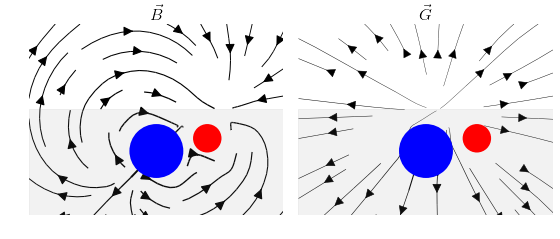

In [183]:
# Plot a dipole field for sketch
xmin, xmax = -5., 5.
zmin, zmax = -5., 5.
nc = 11
R = 1.
x0, y0, z0 = 0.01, 0.01, 0.01
chi = 1
G = 1.
Ho = np.asarray([[1,0,1],np.r_[1,0,1]])

# Compute MAG fields
x, y, z = np.meshgrid(np.linspace(xmin, xmax, nc), np.zeros(1), np.linspace(zmin, zmax, nc))
Bx1, By1, Bz1 = PF.MagAnalytics.MagSphereFreeSpace(x, y, z, R, x0, y0, z0, chi, Ho)
Bx2, By2, Bz2 = PF.MagAnalytics.MagSphereFreeSpace(x, y, z, R/2., x0+2., y0, z0+0.5, chi*2., Ho)

Bx = (Bx1+Bx2).reshape((nc,nc))
Bz = (Bz1+Bz2).reshape((nc,nc))
lBl = np.sqrt(Bx**2. + Bz**2.)

# Compute Gravity field
Gx1, Gz1 = G*(np.pi*R**2.)*np.r_[(x[:]-x0),(z[:]-z0)]/np.sqrt((x-x0)**2.+(z-z0)**2.)
Gx2, Gz2 = G*(10*np.pi*(R/2.)**2.)*np.r_[(x[:]-(x0+2.)),(z[:]-(z0+0.5))]/np.sqrt((x-x0)**2.+(z-z0)**2.)

Gx = (Gx1+Gx2).reshape((nc,nc))
Gz = (Gz1+Gz2).reshape((nc,nc))
lGl = np.sqrt(Gx**2. + Gz**2.)

# Plot vector field
fig = plt.figure(figsize = (8,4))
ax0 = plt.subplot(1,2,1)
lw = 5.*(lBl / lBl.max())**0.1

stp = streamplot(z[0,:,:], x[0,:,:], Bz, Bx,color='k', linewidth=lw, density=0.5,arrowsize=2)
circle1= plt.Circle((x0,z0),R,color='b',fill=True, lw=3)
ax0.add_artist(circle1)
circle1= plt.Circle((x0+2.,z0+0.5),R/2.,color='r',fill=True, lw=3)
ax0.add_artist(circle1)
ax0.add_patch(patches.Rectangle((xmin, zmin),10., 10./1.5, alpha=0.1,color='grey' ))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([xmin,xmax])
plt.ylim([zmin/2.,zmax])
plt.axis('off')
plt.tight_layout()
plt.rc('text', usetex=True)
plt.title(r'$\vec B$')
ax0 = plt.subplot(1,2,2)
lw = 5.*(lGl / lGl.max())**0.5

stp = streamplot(z[0,:,:], x[0,:,:], Gz, Gx,color='k', linewidth=lw, density=0.5,arrowsize=2)
circle1= plt.Circle((x0,z0),R,color='b',fill=True, lw=3)
ax0.add_artist(circle1)
circle1= plt.Circle((x0+2.,z0+0.5),R/2.,color='r',fill=True, lw=3)
ax0.add_artist(circle1)
ax0.add_patch(patches.Rectangle((xmin, zmin),10., 10./1.5, alpha=0.1,color='grey' ))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([xmin,xmax])
plt.ylim([zmin/2.,zmax])
plt.title(r'$\vec G$')
plt.axis('off')
fig.savefig('PF_Sketch.png',dpi = 150)